In [23]:
cd /data/store01/data_dirs/students/ucfafyi/S2_MODIS

/data/store01/data_dirs/students/ucfafyi/S2_MODIS


In [24]:
import sys
sys.path.insert(0,'python')
from LS_optimizing import *
from Dload_Finder import *
import pylab as plt
%matplotlib inline
from linear_plot7 import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
from functools import partial
import multiprocessing

In [17]:
lat, lon, year = 37.181944, 114.36, 2016
doys = get_closet_L(lat, lon, 2016)
Hdoy, Ldoy = np.array(doys[:2])[:,6]
Hsat = 'L'
#optimizing(lat, lon, Hdoy, Ldoy, year, Hsat)
h,v = mtile_cal(lat, lon)
pr=get_wrs(lat, lon)
path, row = pr[0]['path'],pr[0]['row']

In [18]:
doys

(array([  4,  20,  36,  68,  84, 100, 116, 132, 148, 164, 180, 196]),
 array([  1,  17,  33,  65,  81,  97, 113, 129, 145, 161, 177, 193]),
 2016)

In [19]:
Hfile = directory +'l_data/LC8%03d%03d%d%03dLGN00_sr_'%(path, row, year, Hdoy)
Lfile = glob.glob('m_data/MCD43A?.A%d%03d.h%02dv%02d.005.*.hdf'%(year,Ldoy,h,v))

In [20]:
path, row

(124, 34)

In [21]:
with open(Hfile[:-4]+'_MTL.txt', 'r') as inF:
    for line in inF:
        if 'CLOUD_COVER ' in line:
            cloud_cover =  float(line.split('= ')[1])
if cloud_cover<20:
    print 'Less than 20% cloud.'
    b1 = gdal.Open(Hfile+'band1.tif').ReadAsArray()
    corners = b1.shape

    cloud = gdal.Open(Hfile[:-4]+'_cfmask.tif').ReadAsArray()
    cl_mask = (cloud>1)&(cloud<255)

    dic = {}

    with open(Hfile[:-4]+'_MTL.txt', 'r') as inF:
        for line in inF:
            if ('CORNER_' in line)&('LAT_PRODUCT' in line):
                dic[line.split(' = ')[0].strip()[7:13]] = float(line.split(' = ')[1])
            elif ('CORNER_' in line)&('LON_PRODUCT' in line):
                dic[line.split(' = ')[0].strip()[7:13]] = float(line.split(' = ')[1])
            elif 'ROLL_ANGLE' in line:
                vza = float(line.split(' = ')[1])
            elif 'SUN_AZIMUTH' in line:
                saa = float(line.split(' = ')[1])
            elif 'SUN_ELEVATION' in line:
                sza = float(line.split(' = ')[1])
    with open('Landsat_azm.pkl', 'r') as savefile:
        Landsat_azm = pkl.load(savefile)

    lazm = np.nanmean(Landsat_azm[(Landsat_azm[:,2]==path)&(Landsat_azm[:,3]==row)].squeeze()[:2])
    raa = lazm-saa

    L_inds, H_inds = ML_geo_trans(lat, lon, dic, corners)

    modis_filenames = gdal.Open(Lfile[0]).GetSubDatasets()
    modisQAs = gdal.Open(Lfile[1]).GetSubDatasets()

    tems = np.zeros((3,6))
    tems[0,:] = sza
    tems[1,:] = vza
    tems[2,:] = raa

    brdfs, rws = get_rs(modisQAs, modis_filenames, (tems[0], tems[1], tems[2]), bands=[2,3,0,1,5,6])

    args = Hfile, cloud, brdfs, H_inds, L_inds

Less than 20% cloud.


In [7]:
ind=5
Hfile, cloud, brdfs, H_inds, L_inds = args
B_num = L_bands[ind]
H_data = gdal.Open(Hfile+'band%d.tif'%B_num).ReadAsArray()*0.0001
struct = ndimage.generate_binary_structure(2, 2)
dia_cloud = ndimage.binary_dilation(cl_mask, structure=struct, iterations=20).astype(cl_mask.dtype)
mask = ~(H_data<0).astype('bool')
small_mask = ndimage.binary_erosion(mask, structure=struct, iterations=20).astype(mask.dtype)
val_mask = (~dia_cloud)&small_mask
L_data = brdfs[ind]

In [8]:
Lx, Ly = L_inds
Hx, Hy = H_inds
L_inds, H_inds

((array([342, 342, 342, ..., 874, 874, 874]),
  array([ 58,  59,  60, ..., 252, 253, 254])),
 array([[   0,    0,    0, ..., 7999, 8000, 8000],
        [7427, 7442, 7458, ...,  202,  217,  233]]))

In [14]:
def gaussian(xstd, ystd, angle, norm = True):
    win = int(round(max(3*xstd, 3*ystd)))
    winx = win*2**0.5
    winy = win*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-win/2: center[0]+win/2, center[1]-win/2:center[1]+win/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus    

In [10]:
lx, ly = Lx[(Hx>3000)&(Hx<6000)&(Hy>3000)&(Hy<6000)], Ly[(Hx>3000)&(Hx<6000)&(Hy>3000)&(Hy<6000)]
hx, hy = Hx[(Hx>3000)&(Hx<6000)&(Hy>3000)&(Hy<6000)], Hy[(Hx>3000)&(Hx<6000)&(Hy>3000)&(Hy<6000)]

In [11]:
struct = ndimage.generate_binary_structure(2, 2)
border =np.ones((3000,3000))
ero_b = ndimage.binary_erosion(border, structure=struct, iterations=20).astype(bool)

In [12]:
avker = np.ones((40,40))
navker = avker/avker.sum()

In [16]:
def cost(Gps):
    xs, ys = Gps
    s = signal.fftconvolve(H_data[3000:6000, 3000:6000], navker, mode='same')
    # remove the cloud pixel
    outs = (~val_mask[3000:6000, 3000:6000])|(~ero_b)
    s[outs]=np.nan
    val = (hx-3000+xs<3000)&(hy-3000+ys<3000)
    shx, shy = (hx-3000+xs).astype(int), (hy-3000+ys).astype(int)

    Lvals, Hvals =L_data[lx[val], ly[val]]*0.001, s[shx[val], shy[val]]
    mas = (Lvals>0)&(Lvals<1)&(Hvals>0)&(Hvals<1)
    r = scipy.stats.linregress(Lvals[mas], Hvals[mas])
    return abs(1-r.rvalue)

In [17]:
p0 = 17.99999991, 22.68793634
p = np.array(p0)
psolve6 = optimize.fmin(cost,p0,full_output=1)
print psolve6

/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in greater
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in less


Optimization terminated successfully.
         Current function value: 0.060871
         Iterations: 21
         Function evaluations: 67
(array([ 19.3499999 ,  20.41914271]), 0.060871134911576918, 21, 67, 0)


In [24]:
def cost2(paras):
    xs, ys = 19.3499999 ,  20.41914271
    xstd,ystd,angle = paras
    print paras
    xwin,ywin = 40,40
    G = gaussian(xwin,ywin,xstd,ystd,angle,False)                              
    ker = G/(G.sum())
    s = signal.fftconvolve(H_data[3000:6000, 3000:6000], ker, mode='same')
    # remove the cloud pixel
    outs = (~val_mask[3000:6000, 3000:6000])|(~ero_b)
    s[outs]=np.nan
    val = (hx-3000+xs<3000)&(hy-3000+ys<3000)
    shx, shy = (hx-3000+xs).astype(int), (hy-3000+ys).astype(int)

    Lvals, Hvals =L_data[lx[val], ly[val]]*0.001, s[shx[val], shy[val]]
    mas = (Lvals>0)&(Lvals<1)&(Hvals>0)&(Hvals<1)
    r = scipy.stats.linregress(Lvals[mas], Hvals[mas])
    print abs(1-r.rvalue)
    return abs(1-r.rvalue)

In [25]:
p0 = 2, 400, 8
p = np.array(p0)
psolve = optimize.fmin(cost2,p0,full_output=1)
print psolve

[   2.  400.    8.]


/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in greater
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in less


0.0940808112891
[   2.1  400.     8. ]
0.093145243554
[   2.  420.    8.]
0.094080648763
[   2.   400.     8.4]
0.0941392749267
[   2.06666667  413.33333333    7.6       ]
0.0935159942392
[   2.11111111  422.22222222    7.73333333]
0.0930816069814
[   2.16666667  433.33333333    7.6       ]
0.0925868552941
[   2.22222222  411.11111111    7.46666667]
0.0920956421486
[   2.33333333  406.66666667    7.2       ]
0.0911230622378
[   2.33333333  413.33333333    7.6       ]
0.091072115176
[   2.46666667  413.33333333    7.6       ]
0.0898906395182
[   2.54444444  435.55555556    6.93333333]
0.0894015379887
[   2.76666667  453.33333333    6.4       ]
0.0875572481122
[   2.87777778  415.55555556    6.53333333]
0.086626405796
[   3.23333333  406.66666667    6.        ]
0.0838408201016
[   3.31111111  442.22222222    6.13333333]
0.0832405202199
[   3.8  460.     5.6]
0.079622637482
[   4.06666667  466.66666667    4.4       ]
0.0779772089647
[   4.86666667  493.33333333    2.8       ]
0.0730833273

In [26]:
ftol=0.001
xtol = 0.001
p0 = 10, 400, 8
p = np.array(p0)
psolve1 = optimize.fmin(cost2,p0,full_output=1, xtol = xtol, ftol=ftol)
print psolve1

[  10.  400.    8.]


/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in greater
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in less


0.0599863162245
[  10.5  400.     8. ]
0.0596944401504
[  10.  420.    8.]
0.0599864355092
[  10.   400.     8.4]
0.0601034658794
[  10.33333333  413.33333333    7.6       ]
0.059754458489
[  10.55555556  388.88888889    7.73333333]
0.0596483489225
[  10.83333333  373.33333333    7.6       ]
0.0595155317077
[  11.11111111  391.11111111    7.46666667]
0.0594034999712
[  11.66666667  386.66666667    7.2       ]
0.059231439649
[  11.66666667  360.            7.6       ]
0.0592550760223
[  12.27777778  346.66666667    6.93333333]
0.0591739509339
[  13.16666667  320.            6.4       ]
0.0590687989474
[  13.5         337.77777778    6.53333333]
0.0590651053783
[  14.83333333  320.            6.        ]
0.0590701702132
[  13.88888889  336.2962963     5.82222222]
0.0589798010101
[  15.          324.44444444    4.93333333]
0.0589969635857
[  15.37037037  276.04938272    5.3037037 ]
0.059033037613
[  15.33950617  313.41563786    5.37283951]
0.0590334546991
[  16.23251029  279.39643347    4

In [27]:
ftol=0.001
xtol = 0.001
p0 = 13.5, 40, 8
p = np.array(p0)
psolve1 = optimize.fmin(cost2,p0,full_output=1, xtol = xtol, ftol=ftol)
print psolve1

[ 13.5  40.    8. ]


/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in greater
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in less


0.0589706358484
[ 14.175  40.      8.   ]
0.0589701615941
[ 13.5  42.    8. ]
0.0589777617059
[ 13.5  40.    8.4]
0.059048098648
[ 13.95        41.33333333   7.6       ]
0.0589573520263
[ 14.175  42.      7.2  ]
0.0589489155113
[ 14.4         39.33333333   7.46666667]
0.0589550264332
[ 15.          40.88888889   7.11111111]
0.0589755592049
[ 13.875       40.22222222   7.77777778]
0.0589595702276
[ 14.125       41.03703704   6.96296296]
0.0589922741931
[ 14.1625      40.25925926   7.74074074]
0.0589616429222
[ 14.1375      40.77777778   7.22222222]
0.0589449128213
[ 14.125       41.03703704   6.96296296]
0.0589922741931
[ 14.6         41.18518519   6.81481481]
0.0590006173111
[ 14.05625     40.46296296   7.53703704]
0.05895336001
[ 13.84583333  42.82716049   7.17283951]
0.0589458633602
[ 14.04930556  43.27366255   6.85967078]
0.0589942177653
[ 14.05451389  41.16563786   7.36769547]
0.0589497351619
[ 14.05104167  42.57098765   7.02901235]
0.0589423083561
[ 14.04930556  43.27366255   6.85

In [13]:
xstd,ystd,angle = 13.55010886,  303.84095737,    4.72327425
xwin,ywin = 40,40
G = gaussian(xwin,ywin,xstd,ystd,angle,False)
ker1 = G/(G.sum())

In [14]:
xstd,ystd,angle = 13.7771715 ,  28.1733206 ,   6.97497392
xwin,ywin = 40,40
G = gaussian(xwin,ywin,xstd,ystd,angle,False)
ker2 = G/(G.sum())

In [15]:
xstd,ystd,angle = 13.54273914,  29.74708211,  -9.34812365
xwin,ywin = 40,40
G = gaussian(xwin,ywin,xstd,ystd,angle,False)
ker3 = G/(G.sum())

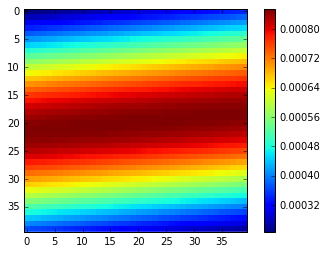

In [16]:
plt.imshow(ker1, interpolation='None')
plt.colorbar()

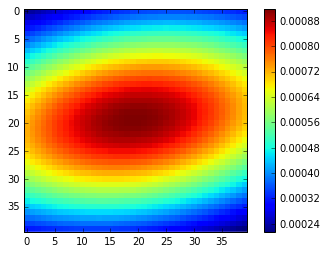

In [17]:
plt.imshow(ker2, interpolation='None')
plt.colorbar()

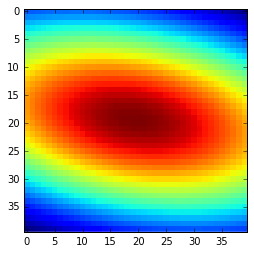

In [18]:
plt.imshow(ker3, interpolation='None')

In [19]:
ker1[10:30,10:30].sum()/ker1.sum(),ker2[10:30,10:30].sum()/ker2.sum(),ker3[10:30,10:30].sum()/ker3.sum()

(0.31360063475642797, 0.33092513240534843, 0.3307969426995821)

In [51]:
p0 = 13.5, 400, 8
p = np.array(p0)
optimize.fmin_l_bfgs_b(cost2,p0, approx_grad=1, iprint=-1)

[  13.5  400.     8. ]


/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in greater
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in less


0.059077494431
[  13.50000001  400.            8.        ]
0.0590774944308
[  13.5         400.00000001    8.        ]
0.059077494431
[  13.5         400.            8.00000001]
0.0590774944315
[  13.87607707  400.00142146    7.0734127 ]
0.0590318299698
[  13.87607708  400.00142146    7.0734127 ]
0.0590318299699
[  13.87607707  400.00142147    7.0734127 ]
0.0590318299698
[  13.87607707  400.00142146    7.07341271]
0.0590318299702
[  14.08623479  400.00483115    2.54201652]
0.0589304168437
[  14.0862348   400.00483115    2.54201652]
0.0589304168441
[  14.08623479  400.00483116    2.54201652]
0.0589304168437
[  14.08623479  400.00483115    2.54201653]
0.058930416844
[  12.68914671  400.02029615   -5.30805326]
0.0588279528023
[  12.68914672  400.02029615   -5.30805326]
0.0588279528017
[  12.68914671  400.02029616   -5.30805326]
0.0588279528023
[  12.68914671  400.02029615   -5.30805325]
0.0588279528022
[  13.53776976  400.01373184   -2.71544588]
0.0587987494053
[  13.53776977  400.0137318

(array([  13.35990578,  400.01502657,   -2.94926681]),
 0.058796886313285723,
 {'funcalls': 24,
  'grad': array([  3.79696274e-06,   5.55111512e-08,   2.33146835e-07]),
  'nit': 5,
  'task': 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
  'warnflag': 0})

In [52]:
p0 = 13.5, 100, 8
p = np.array(p0)
optimize.fmin_l_bfgs_b(cost2,p0, approx_grad=1, iprint=-1)

[  13.5  100.     8. ]


/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in greater
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in less


0.0590568327451
[  13.50000001  100.            8.        ]
0.0590568327449
[  13.5         100.00000001    8.        ]
0.0590568327451
[  13.5         100.            8.00000001]
0.0590568327456
[ 13.9013643   99.99163389   7.08411971]
0.0590132684902
[ 13.90136431  99.99163389   7.08411971]
0.0590132684903
[ 13.9013643   99.9916339    7.08411971]
0.0590132684902
[ 13.9013643   99.99163389   7.08411972]
0.0590132684906
[ 14.19560189  99.96368102   3.02587547]
0.0588848687132
[ 14.1956019   99.96368102   3.02587547]
0.0588848687137
[ 14.19560189  99.96368103   3.02587547]
0.0588848687132
[ 14.19560189  99.96368102   3.02587548]
0.0588848687135
[ 13.21207174  99.79479194  -4.09512229]
0.0588280775492
[ 13.21207175  99.79479194  -4.09512229]
0.058828077549
[ 13.21207174  99.79479195  -4.09512229]
0.0588280775492
[ 13.21207174  99.79479194  -4.09512228]
0.0588280775491
[ 13.41708899  99.79176913  -3.19531727]
0.0587844950175
[ 13.417089    99.79176913  -3.19531727]
0.0587844950175
[ 13.41

(array([ 13.41708899,  99.79176913,  -3.19531727]),
 0.058784495017457306,
 {'funcalls': 20,
  'grad': array([  7.31636973e-06,   7.10542736e-07,  -6.10622664e-07]),
  'nit': 4,
  'task': 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
  'warnflag': 0})

In [53]:
p0 = 2, 100, 8
p = np.array(p0)
optimize.fmin_l_bfgs_b(cost2,p0, approx_grad=1, iprint=-1)

[   2.  100.    8.]


/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in greater
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in less


0.0941083101762
[   2.00000001  100.            8.        ]
0.0941083100818
[   2.          100.00000001    8.        ]
0.0941083101762
[   2.          100.            8.00000001]
0.0941083101746
[   2.99985822  100.00003176    8.01683864]
0.085421625633
[   2.99985823  100.00003176    8.01683864]
0.0854216255537
[   2.99985822  100.00003177    8.01683864]
0.085421625633
[   2.99985822  100.00003176    8.01683865]
0.0854216256322
[   8.27357889  100.00132049    7.90807773]
0.0618411697515
[   8.2735789   100.00132049    7.90807773]
0.0618411697354
[   8.27357889  100.0013205     7.90807773]
0.0618411697515
[   8.27357889  100.00132049    7.90807774]
0.0618411697522
[   9.62172984  100.00115472    7.788163  ]
0.0602353439323
[   9.62172985  100.00115472    7.788163  ]
0.060235343924
[   9.62172984  100.00115473    7.788163  ]
0.0602353439323
[   9.62172984  100.00115472    7.78816301]
0.060235343933
[  11.05018959  100.000153      7.53709934]
0.0594103767177
[  11.0501896   100.000153  

(array([ 13.2502541 ,  99.83150409,  -3.54161563]),
 0.058784926260023074,
 {'funcalls': 48,
  'grad': array([ -5.15143483e-06,   3.10862447e-07,  -2.22044605e-06]),
  'nit': 11,
  'task': 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
  'warnflag': 0})

In [54]:
p0 = 2, 10, 8
p = np.array(p0)
optimize.fmin_l_bfgs_b(cost2,p0, approx_grad=1, iprint=-1)

[  2.  10.   8.]


/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in greater
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in less


0.106095780714
[  2.00000001  10.           8.        ]
0.106095780603
[  2.          10.00000001   8.        ]
0.106095780681
[  2.          10.           8.00000001]
0.106095780713
[  2.95813307  10.28615994   8.0096699 ]
0.0954258063313
[  2.95813308  10.28615994   8.0096699 ]
0.0954258062374
[  2.95813307  10.28615995   8.0096699 ]
0.0954258063044
[  2.95813307  10.28615994   8.00966991]
0.0954258063307
[  8.29719893  11.48028386   7.93372937]
0.0649242159157
[  8.29719894  11.48028386   7.93372937]
0.0649242158959
[  8.29719893  11.48028387   7.93372937]
0.0649242159053
[  8.29719893  11.48028386   7.93372938]
0.0649242159158
[  9.7193283   12.22585704   7.88537958]
0.0622359849671
[  9.71932831  12.22585704   7.88537958]
0.0622359849573
[  9.7193283   12.22585705   7.88537958]
0.0622359849598
[  9.7193283   12.22585704   7.88537959]
0.0622359849672
[ 11.21741454  13.67164484   7.8098945 ]
0.0604540173247
[ 11.21741455  13.67164484   7.8098945 ]
0.0604540173207
[ 11.21741454  13.6

(array([ 13.53814957,  31.77585504,  -4.45439459]),
 0.058780296136730859,
 {'funcalls': 48,
  'grad': array([  7.00550729e-06,  -1.07691633e-06,  -1.24344979e-06]),
  'nit': 11,
  'task': 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
  'warnflag': 0})

In [55]:
p0 = 2, 40, 8
p = np.array(p0)
optimize.fmin_l_bfgs_b(cost2,p0, approx_grad=1, iprint=-1)

[  2.  40.   8.]


/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in greater
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in less


0.0943081664429
[  2.00000001  40.           8.        ]
0.094308166348
[  2.          40.00000001   8.        ]
0.0943081664427
[  2.          40.           8.00000001]
0.0943081664413
[  2.99985243  40.00152142   8.01711127]
0.0855710338963
[  2.99985244  40.00152142   8.01711127]
0.0855710338165
[  2.99985243  40.00152143   8.01711127]
0.0855710338962
[  2.99985243  40.00152142   8.01711128]
0.0855710338955
[  8.31275172  40.00510492   7.90498527]
0.0617310086358
[  8.31275173  40.00510492   7.90498527]
0.0617310086198
[  8.31275172  40.00510493   7.90498527]
0.0617310086358
[  8.31275172  40.00510492   7.90498528]
0.0617310086365
[  9.64979255  40.00284408   7.79357194]
0.0601464701564
[  9.64979256  40.00284408   7.79357194]
0.0601464701482
[  9.64979255  40.00284409   7.79357194]
0.0601464701565
[  9.64979255  40.00284408   7.79357195]
0.0601464701571
[ 11.07864398  39.99381305   7.56842179]
0.0593267679335
[ 11.07864399  39.99381305   7.56842179]
0.05932676793
[ 11.07864398  39.

(array([ 13.94229139,  39.06517691,  -1.52834735]),
 0.058755461805334086,
 {'funcalls': 312,
  'grad': array([  3.68705066e-05,   1.29896094e-06,   6.66133815e-06]),
  'nit': 15,
  'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
  'warnflag': 0})

In [38]:
def cost (paras):
#def cost(xstd,ystd,angle, xs, ys):
    xstd,ystd,angle, xs, ys = paras[0]
    angle = np.arccos ( angle )*180/np.pi
    xwin,ywin = 40,40
    G = gaussian(xwin,ywin,xstd,ystd,angle,False)                              
    ker = G/(G.sum())
    s = signal.fftconvolve(H_data[3000:6000, 3000:6000], ker, mode='same')
    # remove the cloud pixel
    outs = (~val_mask[3000:6000, 3000:6000])|(~ero_b)
    s[outs]=np.nan
    val = (hx-3000+xs<3000)&(hy-3000+ys<3000)
    shx, shy = (hx-3000+xs).astype(int), (hy-3000+ys).astype(int)

    Lvals, Hvals =L_data[lx[val], ly[val]]*0.001, s[shx[val], shy[val]]
    mas = (Lvals>0)&(Lvals<1)&(Hvals>0)&(Hvals<1)
    r = scipy.stats.linregress(Lvals[mas], Hvals[mas])
    return abs(1-r.rvalue)

In [40]:
import gp_emulator
parameters = ["xstd", 'ystd', 'angle', 'xs','ys']
minvals = [1, 1, 0, -40, -40]
maxvals = [ 100, 300, np.cos(np.pi/4.), 40, 40]
retval=gp_emulator.create_emulator_validation( cost, parameters, minvals, maxvals, 
                                       250, n_validate=10, n_tries=10, n_procs=16)

/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in greater
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in less
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in greater
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in less
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in greater
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in 

After 10, the minimum cost was -3.171528e+02


/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in greater
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in less


In [1]:
def cost3(paras):
    ystd = paras
    xs, ys = 19.3499999 ,  20.41914271
    xstd, angle = 13.94229139, -3.20
    print paras
    xwin,ywin = 40,40
    G = gaussian(xwin,ywin,xstd,ystd,angle,False)                              
    ker = G/(G.sum())
    s = signal.fftconvolve(H_data[3000:6000, 3000:6000], ker, mode='same')
    # remove the cloud pixel
    outs = (~val_mask[3000:6000, 3000:6000])|(~ero_b)
    s[outs]=np.nan
    val = (hx-3000+xs<3000)&(hy-3000+ys<3000)
    shx, shy = (hx-3000+xs).astype(int), (hy-3000+ys).astype(int)

    Lvals, Hvals =L_data[lx[val], ly[val]]*0.001, s[shx[val], shy[val]]
    mas = (Lvals>0)&(Lvals<1)&(Hvals>0)&(Hvals<1)
    r = scipy.stats.linregress(Lvals[mas], Hvals[mas])
    print abs(1-r.rvalue)
    return abs(1-r.rvalue)  

In [46]:
p0 = 50
p = np.array(p0)
optimize.fmin_l_bfgs_b(cost3,p0, approx_grad=1, iprint=-1)

[ 50.]


/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in greater
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in less


0.0587651703334
[ 50.00000001]
0.0587651703334


(array([ 50.]),
 0.058765170333416772,
 {'funcalls': 2,
  'grad': array([  6.10622664e-07]),
  'nit': 0,
  'task': 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
  'warnflag': 0})

In [48]:
p0 = 100
p = np.array(p0)
optimize.fmin(cost3,p0, full_output=1)

[ 100.]


/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in greater
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in less


0.0587969532942
[ 105.]
0.0587981728311
[ 95.]
0.0587955540417
[ 90.]
0.0587939395582
[ 80.]
0.0587898777146
[ 70.]
0.0587842687934
[ 50.]
0.0587651703334
[ 30.]
0.0587466349814
[-10.]
0.0630136381145
[ 50.]
0.0587651703334
[ 10.]
0.0630136381145
[ 40.]
0.0587508117888
[ 20.]
0.058922365368
[ 35.]
0.0587448488797
[ 40.]
0.0587508117888
[ 32.5]
0.0587440156333
[ 30.]
0.0587466349814
[ 33.75]
0.0587441317397
[ 31.25]
0.0587447407936
[ 33.125]
0.0587439852695
[ 33.75]
0.0587441317397
[ 32.8125]
0.0587439764549
[ 32.5]
0.0587440156333
[ 32.96875]
0.058743975111
[ 33.125]
0.0587439852695
[ 32.890625]
0.0587439743149
[ 32.8125]
0.0587439764549
[ 32.9296875]
0.0587439743498
[ 32.8515625]
0.0587439750141
[ 32.91015625]
0.0587439742411
[ 32.9296875]
0.0587439743498
[ 32.90039062]
0.0587439742551
[ 32.91992188]
0.0587439742727
[ 32.90527344]
0.0587439742424
[ 32.91503906]
0.0587439742512
[ 32.90771484]
0.0587439742403
[ 32.90527344]
0.0587439742424
[ 32.90893555]
0.0587439742403
[ 32.90649414]
0

(array([ 32.9082489]), 0.058743974240231034, 23, 46, 0)

In [49]:
p0 = 10
p = np.array(p0)
optimize.fmin(cost3,p0, full_output=1)

[ 10.]


/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in greater
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in less


0.0630136381145
[ 10.5]
0.062335659379
[ 11.]
0.0617704081286
[ 11.5]
0.0612988935252
[ 12.5]
0.0605756459726
[ 13.5]
0.060067418444
[ 15.5]
0.0594488421103
[ 17.5]
0.0591260588671
[ 21.5]
0.0588557238425
[ 25.5]
0.0587720564734
[ 33.5]
0.058744053789
[ 41.5]
0.0587530096095
[ 41.5]
0.0587530096095
[ 37.5]
0.0587474247662
[ 29.5]
0.0587478156216
[ 35.5]
0.0587452626941
[ 31.5]
0.0587445142294
[ 32.5]
0.0587440156333
[ 31.5]
0.0587445142294
[ 33.]
0.0587439762379
[ 33.5]
0.058744053789
[ 32.75]
0.0587439803225
[ 33.25]
0.0587440013598
[ 32.875]
0.0587439745061
[ 32.75]
0.0587439803225
[ 32.9375]
0.0587439744442
[ 33.]
0.0587439762379
[ 32.90625]
0.0587439742412
[ 32.875]
0.0587439745061
[ 32.921875]
0.0587439742845
[ 32.890625]
0.0587439743149
[ 32.9140625]
0.0587439742482
[ 32.8984375]
0.0587439742634
[ 32.91015625]
0.0587439742411
[ 32.9140625]
0.0587439742482
[ 32.90820312]
0.0587439742402
[ 32.90625]
0.0587439742412
[ 32.90917969]
0.0587439742404
[ 32.90722656]
0.0587439742405
[ 32.

(array([ 32.90826416]), 0.058743974240229924, 23, 46, 0)

In [50]:
p0 = 200
p = np.array(p0)
optimize.fmin(cost3,p0, full_output=1)

[ 200.]


/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in greater
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in less


0.0588071979148
[ 210.]
0.0588075302538
[ 190.]
0.0588068128559
[ 180.]
0.0588063633893
[ 160.]
0.0588052062455
[ 140.]
0.0588035383945
[ 100.]
0.0587969532942
[ 60.]
0.058776356477
[-20.]
0.058922365368
[ 100.]
0.0587969532942
[ 20.]
0.058922365368
[ 80.]
0.0587898777146
[ 40.]
0.0587508117888
[ 20.]
0.058922365368
[ 20.]
0.058922365368
[ 50.]
0.0587651703334
[ 30.]
0.0587466349814
[ 20.]
0.058922365368
[ 20.]
0.058922365368
[ 35.]
0.0587448488797
[ 40.]
0.0587508117888
[ 32.5]
0.0587440156333
[ 30.]
0.0587466349814
[ 33.75]
0.0587441317397
[ 31.25]
0.0587447407936
[ 33.125]
0.0587439852695
[ 33.75]
0.0587441317397
[ 32.8125]
0.0587439764549
[ 32.5]
0.0587440156333
[ 32.96875]
0.058743975111
[ 33.125]
0.0587439852695
[ 32.890625]
0.0587439743149
[ 32.8125]
0.0587439764549
[ 32.9296875]
0.0587439743498
[ 32.8515625]
0.0587439750141
[ 32.91015625]
0.0587439742411
[ 32.9296875]
0.0587439743498
[ 32.90039062]
0.0587439742551
[ 32.91992188]
0.0587439742727
[ 32.90527344]
0.0587439742424
[ 

(array([ 32.9082489]), 0.058743974240231034, 26, 52, 0)

In [13]:
def cost4(para):
    xstd, ystd, angle = para
    xs, ys = 19.3499999 ,  20.41914271
    xwin,ywin = 40,40
    G = gaussian(xwin,ywin,xstd,ystd,angle,False)                              
    ker = G/(G.sum())
    s = signal.fftconvolve(H_data[3000:6000, 3000:6000], ker, mode='same')
    # remove the cloud pixel
    outs = (~val_mask[3000:6000, 3000:6000])|(~ero_b)
    s[outs]=np.nan
    val = (hx-3000+xs<3000)&(hy-3000+ys<3000)
    shx, shy = (hx-3000+xs).astype(int), (hy-3000+ys).astype(int)
    Lvals, Hvals =L_data[lx[val], ly[val]]*0.001, s[shx[val], shy[val]]
    mas = (Lvals>0)&(Lvals<1)&(Hvals>0)&(Hvals<1)
    r = scipy.stats.linregress(Lvals[mas], Hvals[mas])
    cost = abs(1-r.rvalue)
    return para + (cost,)  

In [15]:
pars = np.mgrid[1:100:1, 1:100:1, 0:45:1]
pars[0].flatten(), pars[1].flatten(), pars[2].flatten()

(array([ 1,  1,  1, ..., 99, 99, 99]),
 array([ 1,  1,  1, ..., 99, 99, 99]),
 array([ 0,  1,  2, ..., 42, 43, 44]))

In [16]:
paras = zip(pars[0].flatten(), pars[1].flatten(), pars[2].flatten())

In [ ]:
for para in paras:   
    cos = cost4(para)
    print cos

In [ ]:
pool = multiprocessing.Pool(processes = 32)
retval = pool.map(cost4, paras)
pool.close()
pool.join()

/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in greater
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in less
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in greater
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in less
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in less
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in gre

In [25]:
parallel_rw_pkl(np.array(retval), 'cost_func', 'w')

In [28]:
Jfunc = np.array(retval)

In [37]:
np.where(Jfunc[:,3] == np.min(Jfunc[:,3]))

(array([54901]),)

In [38]:
Jfunc[np.where(Jfunc[:,3] == np.min(Jfunc[:,3]))[0]]

array([ 13.        ,  33.        ,   1.        ,   0.05877348])

In [27]:
1- 0.05877348

0.94122652

In [42]:
optimal_angle = Jfunc[np.where(Jfunc[:,2] == 1)]

In [49]:
base= np.zeros((99,99))

In [70]:
base[optimal_angle[:,0].astype(int)-1, optimal_angle[:,1].astype(int)-1] = optimal_angle[:,3]

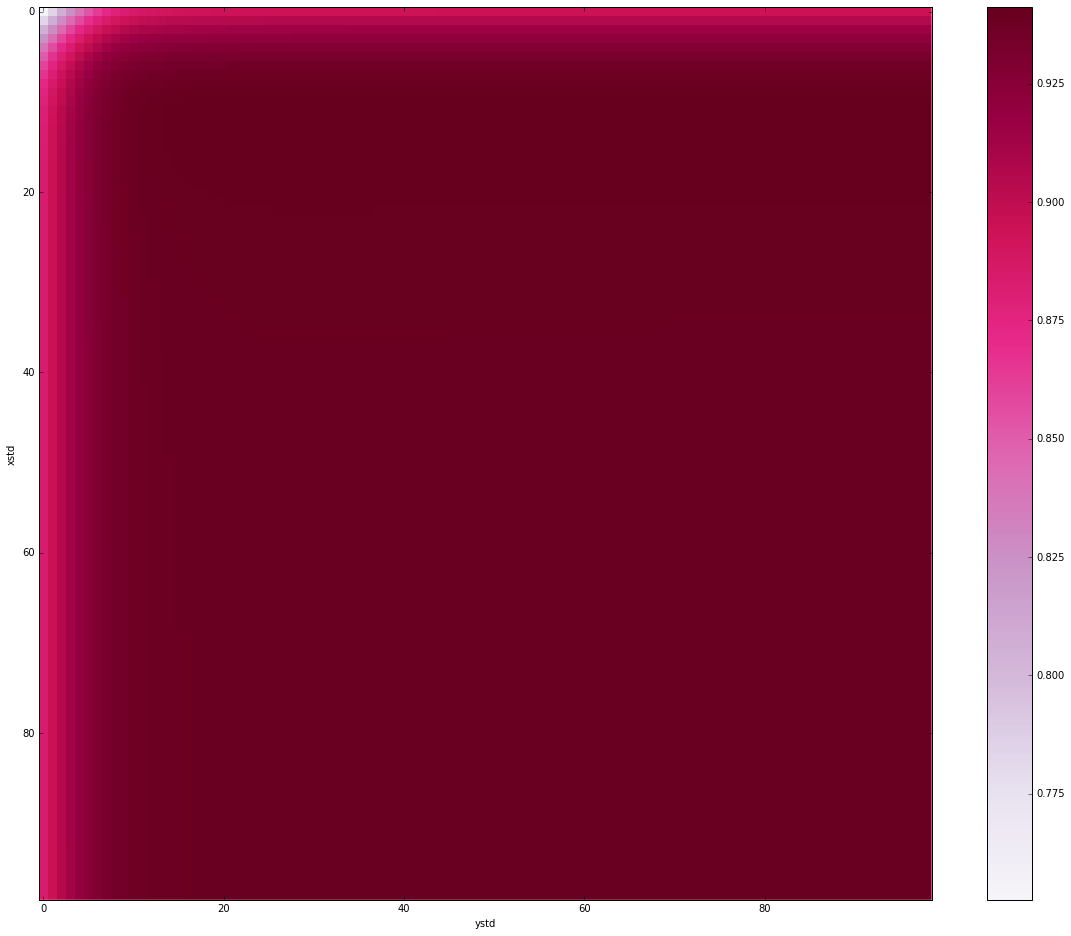

In [144]:
plt.figure(figsize=(20,16))
plt.imshow(1-base, cmap=plt.cm.get_cmap('PuRd'), interpolation='None')
plt.ylabel('xstd')
plt.xlabel('ystd')
plt.colorbar()
plt.savefig('erosurface.pdf') 

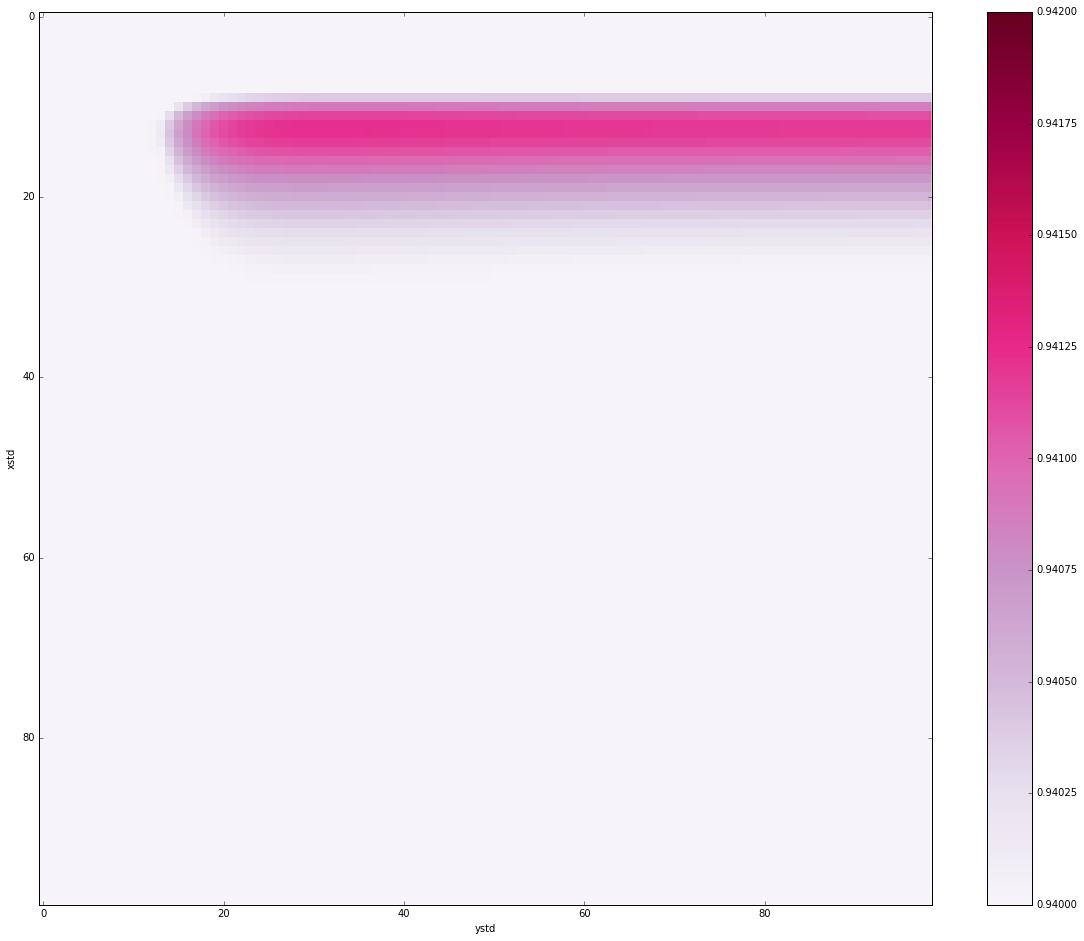

In [103]:
plt.figure(figsize=(20,16))
plt.imshow(1-base, cmap=plt.cm.get_cmap('PuRd'), interpolation='None', vmin=0.94, vmax=0.942)
plt.ylabel('xstd')
plt.xlabel('ystd')
plt.colorbar()
plt.savefig('erosurface.pdf') 

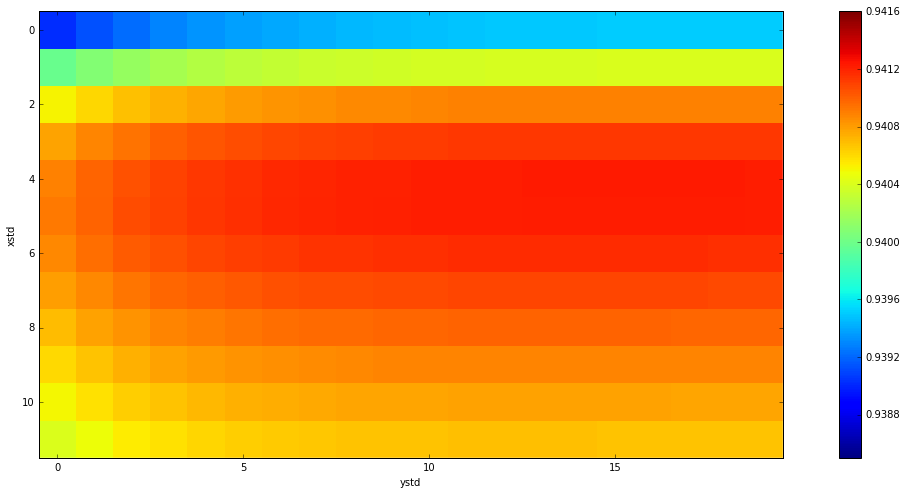

In [140]:
plt.figure(figsize=(20,8))
plt.imshow((1-base)[8:20,17:37], cmap=plt.cm.get_cmap('jet'), interpolation='None', vmin=0.9385, vmax=0.9416)
plt.ylabel('xstd')
plt.xlabel('ystd')
plt.colorbar()

In [147]:
angles = Jfunc[np.where((Jfunc[:,0] == 13.)&(Jfunc[:,1] == 33.))]

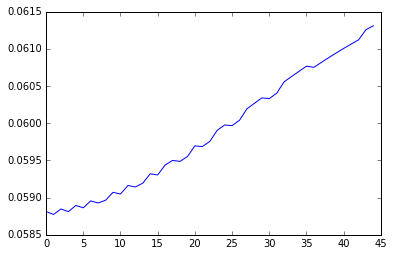

In [149]:
plt.plot(angles[:,-1])

In [151]:
angles[:,-1][:5]

array([ 0.05881279,  0.05877348,  0.05884692,  0.05881148,  0.05889465])